# Intro

This book is a brief exploration of various procedures for calculating predictions from test time augmentations.

The test time augmentation procedure implemented below results in 42 versions of each original image, based on five crops from four  scales with horizontal flips, plus the original image and its horizontal flip. This procedure is an abbreviated version of the procedure followed in the [Going deeper with convolutions paper](https://arxiv.org/pdf/1409.4842.pdf), which was cited in the recent [Big Transfer paper](https://arxiv.org/pdf/1912.11370.pdf).

Three different prediction procedures are evaluated against baseline predictions for original images, including:

* Argmax of average of softmax probs of each image version
* Argmax of max of softmax probs of each image version
* Mode of argmax of softmax probs of each image version
* Argmax of softmax of average of logits of each image version

To enable this book to run quickly, predictions for comparison are generated from the relatively small Efficientnet-B0 model (4.1 million parameters), trained on only images from the training set with an original size of 224x224. Training images are augmented with random horizontal flip, scale and crop. The model starts with noisy-student pretrained weights and runs for 30 epochs using sparse categorical cross entropy for the loss function and Adam for the optimizer. The base batch size is 16 (128 across 8 replicas) and the base learning rate is 0.003 (0.0015 following the batch_size / 256 convention).

The baseline macro f1-score s 0.921. The best score of 0.933 results from averaging softmax probs, a 16% reduction in total error (numbers may vary slightly with different runs of this book).

# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from google.cloud import storage
import json
import math
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report
import subprocess
import sys
import tensorflow as tf
import time
from tqdm.notebook import tqdm

from tensorflow.keras.backend import dot

In [3]:
def porc(c):
    print_output(run_command(c))

def print_output(output):
    """Prints output from string."""
    for l in output.split('\n'):
        print(l)      

def run_command(command):
    """Runs command line command as a subprocess returning output as string."""
    STDOUT = subprocess.PIPE
    process = subprocess.run(command, shell=True, check=False,
                             stdout=STDOUT, stderr=STDOUT, universal_newlines=True)
    return process.stdout

def show_images(imgs, titles=None, hw=(3,3), rc=(4,4)):
    """Show list of images with optional list of titles."""
    h, w = hw
    r, c = rc
    fig=plt.figure(figsize=(w*c, h*r))
    gs1 = gridspec.GridSpec(r, c, fig, hspace=0.2, wspace=0.05)
    for i in range(r*c):
        img = imgs[i].squeeze()
        ax = fig.add_subplot(gs1[i])
        if titles != None:
            ax.set_title(titles[i], {'fontsize': 10})
        plt.imshow(img)
        plt.axis('off')
    plt.show()

In [4]:
output = run_command('pip freeze | grep efficientnet')
if output == '':
    print_output(run_command('pip install efficientnet'))
else:
    print_output(output)
from efficientnet import tfkeras as efn

In [5]:
# raise SystemExit("Stop right there!")

KAGGLE = os.getenv('KAGGLE_KERNEL_RUN_TYPE') != None
BUCKET = 'flowers-caleb'
TFRECORD_DIR = f'gs://{BUCKET}'
DATASET_DIR = Path('flowers-tta')

if KAGGLE:
    from kaggle_datasets import KaggleDatasets
    DATASET_DIR = '/kaggle/input'/DATASET_DIR
    GCS_DATASET_DIR = KaggleDatasets().get_gcs_path(DATASET_DIR.parts[-1])
    PATH = Path('/kaggle/input/flower-classification-with-tpus')
    TFRECORD_DIR = KaggleDatasets().get_gcs_path(PATH.parts[-1])
else:
    GOOGLE_DRIVE = Path('/content/drive/My Drive')

    from google.colab import drive
    drive.mount('/content/drive')
    
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'{GOOGLE_DRIVE}/credentials/google.json'

client = storage.Client(project='fastai-caleb')
bucket = client.get_bucket(BUCKET)

SIZES = {s: f'{s}x{s}' for s in [192, 224, 331, 512]}
AUTO = tf.data.experimental.AUTOTUNE

In [6]:
if not KAGGLE:
    output = run_command('pip freeze | grep gcsfs')
    if output == '':
        print_output(run_command('pip install gcsfs'))
    else:
        print_output(output)

    output = run_command('pip freeze | kaggle')
    if output == '':
        print_output(run_command('pip install kaggle'))
        KAGGLE_PATH = Path('/root/.kaggle/kaggle.json')
        KAGGLE_PATH.parent.mkdir(exist_ok=True)
        kaggle_json = (GOOGLE_DRIVE/'credentials/kaggle.json').read_text()
        KAGGLE_PATH.write_text(kaggle_json)
        KAGGLE_PATH.chmod(600)
    else:
        print_output(output)

In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    for d in tf.config.list_physical_devices():
        print(d)

Running on TPU  grpc://10.0.0.2:8470


# Dataset Functions

In [8]:
def augment(example):
    new_example = example.copy()
    image = example['image']
    
    image = tf.image.random_flip_left_right(image)
    
    shape = tf.shape(image)
    max_resize = tf.cast(tf.cast(shape[-2], tf.float32) * 0.075, tf.int32)
    image = tf.image.resize(image, tf.shape(image)[1:3] + tf.random.uniform((),0, max_resize, tf.int32))
    image = tf.image.random_crop(image, shape)

    new_example['image'] = tf.cast(image, tf.uint8)
    
    return new_example

def get_tta_fn(input_size=(224, 224), scale_factor=1.0):
    resize_factors = (np.array([256., 288., 320., 352.]) - 224) * scale_factor
    resize_factors = tf.constant(224. / (resize_factors + 224.), tf.float32)

    def get_crops(r):
        return np.array([[0, 0, r, r], # top-left
                            [0, 1-r, r, 1], # top-right
                            [1-r, 0, 1, r], # bottom-left
                            [1-r, 1-r, 1, 1], # bottom-right
                            [(1-r)/2,(1-r)/2,1-(1-r)/2,1-(1-r)/2]]) # center
            
    boxes = tf.reshape(tf.map_fn(get_crops, resize_factors),(20,4))

    def tta(example):
        image = example['image']
        del example['image']
        new_example = {}

        cropped = tf.image.crop_and_resize(image, boxes, tf.zeros(20, tf.int32),
                                           input_size)
        
        flipped = tf.image.flip_left_right(cropped)

        image = tf.cast(tf.image.resize(image, input_size), tf.uint8)

        new_example['image'] = tf.concat([image, tf.image.flip_left_right(image),
                                          tf.cast(cropped, tf.uint8),
                                          tf.cast(flipped, tf.uint8)], axis=0)
        for k in example:
            new_example[k] = tf.repeat(example[k], 42) 

        return new_example

    return tta

def get_preprocess_fn(input_size=(224, 224), batch_size=128, norm=None, test=False):
    
    def imagenet_norm(image):
        mean = tf.constant([0.485, 0.456, 0.406])
        std = tf.constant([0.229, 0.224, 0.225])
        
        return (image / tf.constant(255, tf.float32) - mean) / std
    
    norm_fn = {'per_image': tf.image.per_image_standardization,
               'imagenet': imagenet_norm,
               None: tf.image.per_image_standardization
              }

    def preprocess(batch):
        image = tf.image.resize(batch['image'], input_size)
        image = norm_fn[norm](image)

        if test:
            return image
        
        else:
            image = tf.reshape(image, (batch_size, *input_size, 3))
            label = tf.cast(batch['label'], tf.float32)
            label = tf.reshape(label, (batch_size,))
                
            return image, label
        
    return preprocess

classes_filename = DATASET_DIR/'classes.csv' if KAGGLE else f'gs://{BUCKET}/classes.csv' 
CLASSES = tf.constant(pd.read_csv(classes_filename).values.squeeze(), tf.string)
def get_parse_fn(split):
    def parse_fn(example):
        features = {"image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
                    "id": tf.io.FixedLenFeature([], tf.string),
                    "class": tf.io.FixedLenFeature([], tf.int64)}
                
        example = tf.io.parse_single_example(example, features)

        example['image'] = tf.image.decode_jpeg(example['image'], channels=3)        
        example['label'] = tf.cast(example['class'], tf.int32)
        example['class'] = CLASSES[example['label']]
        
        return example

    return parse_fn

def get_ds(split, img_size=224, batch_size=128, shuffle=False, repeat=False):
    file_pat = get_file_pat(split, img_size)
    
    options = tf.data.Options()
    options.experimental_deterministic = not shuffle
    
    ds = (tf.data.Dataset.list_files(file_pat, shuffle=shuffle)
          .with_options(options)
          .interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
          .map(get_parse_fn(split), num_parallel_calls=AUTO)
         )
    
    if repeat:
        ds = ds.repeat()
             
    return ds.prefetch(AUTO)

def get_ds_splits(splits, img_size=224, batch_size=128, shuffle=True, repeat=False):
    """splits is a dict of {split: weight} for each split to include"""
        
    ds_dict = {split: get_ds(split, img_size, batch_size, shuffle, repeat) \
               for split in splits}
    
    ds = tf.data.experimental.sample_from_datasets([ds_dict[s] for s in splits], \
                                                   [splits[s] for s in splits])
        
    if 'train' in splits:
        ds = ds.shuffle(4096).batch(batch_size).map(augment, num_parallel_calls=AUTO)
    
    else:
        ds = ds.batch(batch_size)
    
    return ds.prefetch(AUTO)

def get_file_pat(split, img_size):
    return f'{TFRECORD_DIR}/tfrecords-jpeg-{SIZES[img_size]}/{split}/*.tfrec'

In [9]:
ds = get_ds('val').batch(16)
ds_iter = iter(ds)

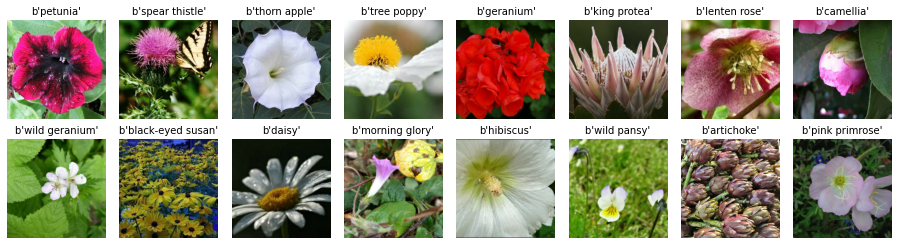

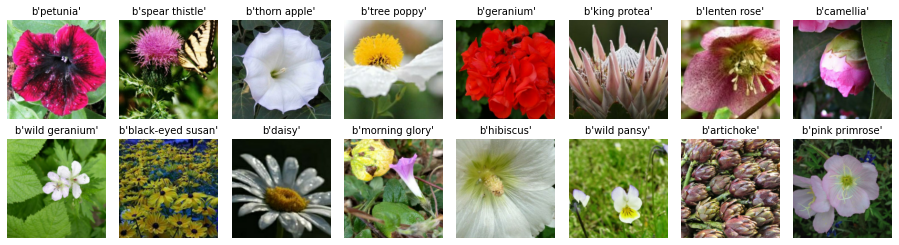

In [10]:
b = next(ds_iter)
b_aug = augment(b)
show_images(b['image'].numpy(), b['class'].numpy().tolist(), hw=(2,2), rc=(2,8))
show_images(b_aug['image'].numpy(), b_aug['class'].numpy().tolist(), hw=(2,2), rc=(2,8))

# Class Weights

In [11]:
splits = ['train', 'val']

def split_classes(split):
    return [b['label'].numpy() for b in get_ds(split)]

df_split_stats = pd.concat([pd.Series(split_classes(s)).value_counts() for s in splits], axis=1).fillna(0)
df_split_stats.columns = splits

Training and validation splits have similar distributions with respect to label.

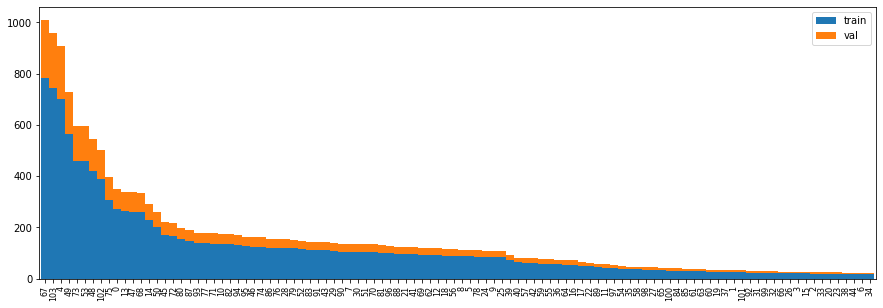

In [12]:
df_split_stats['total'] = df_split_stats[splits].sum(axis=1)
df_split_stats.sort_values('total', ascending=False)[splits].plot(kind='bar', stacked=True, width=1.0, figsize=(15,5))
plt.xticks(fontsize=8);

Class weights are calculated based on frequency relative to max class frequency.

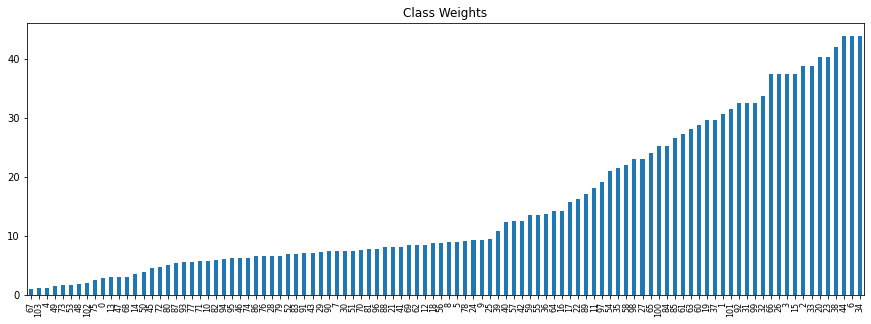

In [13]:
df_split_stats['weight'] = df_split_stats.sum(axis=1).max() / df_split_stats.sum(axis=1)
ax = df_split_stats.sort_values('total', ascending=False)['weight'] \
.plot(kind='bar', figsize=(15,5), title='Class Weights')
plt.xticks(fontsize=8);

# Training Datasets

In [14]:
img_size = 224
input_size = (224, 224)
batch_size = 16 * strategy.num_replicas_in_sync
base_lr = .003
reference_lr = batch_size / 256 * base_lr
lr_start = reference_lr / 25
lr_end = reference_lr / 100

print('reference_lr:', reference_lr)

train_splits = {'train': 12.7}
ds_train = get_ds_splits(train_splits, img_size=img_size, batch_size=batch_size, \
                         shuffle=True, repeat=True)

valid_splits = {'val': 3.7}
ds_valid = get_ds_splits(valid_splits, img_size=img_size, batch_size=batch_size, \
                         shuffle=False)

preprocess = get_preprocess_fn(batch_size=batch_size,
                               input_size=input_size, norm='imagenet')

ds_train_fit = ds_train.map(preprocess, num_parallel_calls=AUTO)
ds_valid_fit = ds_valid.map(preprocess, num_parallel_calls=AUTO)

reference_lr: 0.0015


In [15]:
print('split', '\t', 'items', '\t',  'steps')
split_dict = {}
for split in splits:
    items = 0
    prefix = '/'.join(get_file_pat(split, img_size).split('/')[3:-1])
    for b in bucket.list_blobs(prefix=prefix):
        items += int(b.name.split('.')[0][-3:])
    split_dict[split] = items // batch_size
    print(split, '\t', items, '\t',  items // batch_size)

split 	 items 	 steps
train 	 12753 	 99
val 	 3712 	 29


In [16]:
total_steps = int(512 / batch_size * 500 * 1.5) 
steps_per_epoch = sum([split_dict[split] for split in train_splits])
val_steps = sum([split_dict[split] for split in valid_splits])
epochs = total_steps // steps_per_epoch
print(total_steps, steps_per_epoch, val_steps, epochs)

3000 99 29 30


# Learning Rate Schedule 

In [17]:
# https://docs.fast.ai/callbacks.one_cycle.html
# https://sgugger.github.io/the-1cycle-policy.html

class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, epochs_up=5, epochs_across=5, epochs_down=15, lr_max=0.001,
              lr_start=.00003, lr_end=0.00001, decay=0.93,
              mo_max=0.95, mo_min=0.85):

        super(OneCycleScheduler, self).__init__()

        def one_cycle(epoch):

            if epoch <= epochs_up:
                new_lr = (lr_max - lr_start)/2  * (-math.cos((math.pi * epoch) / epochs_up) + 1) + lr_start
                new_mo = (mo_max - mo_min)/2  * (math.cos((math.pi * epoch) / epochs_up) + 1) + mo_min
            
            elif epoch <= (epochs_up + epochs_across):
                new_lr = lr_max
                new_mo = mo_min
            
            elif epoch <= (epochs_up + epochs_across + epochs_down):
                down_epoch = epoch - epochs_across - epochs_up
                new_lr = (lr_max - lr_end)/2  * (math.cos((math.pi * down_epoch) / epochs_down) + 1) + lr_end
                new_mo = (mo_max - mo_min)/2  * (-math.cos((math.pi * down_epoch) / epochs_down) + 1) + mo_min

            else:
                new_lr = lr_end * decay**(epoch - epochs_up - epochs_across - epochs_down)
                new_mo = mo_max
            
            return new_lr, new_mo

        self.schedule = one_cycle
 
    def on_epoch_begin(self, epoch, logs):
        scheduled_lr, scheduled_mo = self.schedule(epoch)
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        tf.keras.backend.set_value(self.model.optimizer.beta_1, scheduled_mo)
        print(f'\nepoch {epoch+1:02d}: learning_rate={scheduled_lr:0.3e}, beta_1={scheduled_mo:0.3e}')

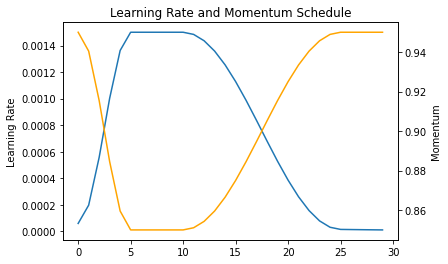

In [18]:
one_cycle = OneCycleScheduler(lr_max=reference_lr, lr_start=lr_start, \
                              lr_end=lr_end).schedule
fig,ax = plt.subplots()
ax2=ax.twinx()
ax.set_ylabel('Learning Rate')
ax2.set_ylabel('Momentum')
plt.title('Learning Rate and Momentum Schedule');
ax.plot([one_cycle(e)[0] for e in range(epochs)], label='lr')
ax2.plot([one_cycle(e)[1] for e in range(epochs)], c='orange', label='beta_1');

# Model

In [19]:
with strategy.scope():
    cnn = efn.EfficientNetB0(weights='noisy-student', include_top=False,
                             pooling='avg', input_shape=(*input_size, 3))
    
    output = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(cnn.output)
    
    model = tf.keras.Model(cnn.input, output)

    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()] 

    model.compile(loss=loss_fn, optimizer=opt, metrics=metrics)

model.summary()

16703488/16696600 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
_____________________________

In [20]:
history = model.fit(ds_train_fit,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=ds_valid_fit,
                    validation_steps=val_steps,
                    validation_freq=5,
                    callbacks=[OneCycleScheduler(lr_max=reference_lr, \
                                                 lr_start=lr_start, \
                                                 lr_end=lr_end)],
                    class_weight=df_split_stats.weight.to_dict()
                    )

Train for 99 steps, validate for 29 steps

epoch 01: learning_rate=6.000e-05, beta_1=9.500e-01
Epoch 1/30
99/99 [==============================] - 64s 644ms/step - loss: 28.7910 - sparse_categorical_accuracy: 0.0438

epoch 02: learning_rate=1.975e-04, beta_1=9.405e-01
Epoch 2/30
99/99 [==============================] - 7s 76ms/step - loss: 19.1665 - sparse_categorical_accuracy: 0.3516

epoch 03: learning_rate=5.575e-04, beta_1=9.155e-01
Epoch 3/30
99/99 [==============================] - 7s 75ms/step - loss: 6.2531 - sparse_categorical_accuracy: 0.6978

epoch 04: learning_rate=1.002e-03, beta_1=8.845e-01
Epoch 4/30
99/99 [==============================] - 7s 75ms/step - loss: 3.5258 - sparse_categorical_accuracy: 0.8015

epoch 05: learning_rate=1.362e-03, beta_1=8.595e-01
Epoch 5/30
99/99 [==============================] - 16s 160ms/step - loss: 2.9913 - sparse_categorical_accuracy: 0.8249 - val_loss: 6.6232 - val_sparse_categorical_accuracy: 0.7150

epoch 06: learning_rate=1.500e-03, 

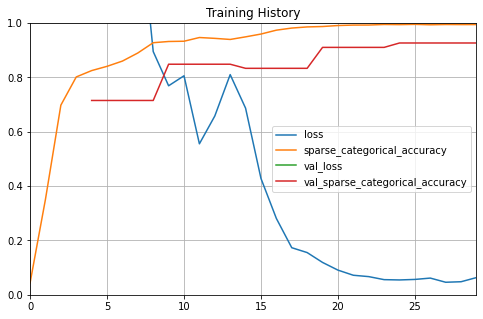

In [21]:
df_hist = pd.DataFrame({m: v for m, v in history.history.items() if 'val' not in m})

for m in [m for m in history.history if 'val' in m]:
    s = pd.Series(history.history[m], index=list(range(epochs))[4::5]) \
    .reindex(range(epochs), method='ffill')
    
    df_hist[m] = s

df_hist.plot(figsize=(8, 5), title='Training History')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Predictions

## Test Time Augmentations

Here is a description of a test time augmentation procedure from the paper [Going deeper with convolutions](https://arxiv.org/pdf/1409.4842.pdf), which was cited in the recent [Big Transfer paper](https://arxiv.org/pdf/1912.11370.pdf).
* *During testing, we adopted a more aggressive cropping approach than that of Krizhevsky etal. [9]. Specifically, we resize the image to 4 scales where the shorter dimension (height or width) is 256, 288, 320 and 352 respectively, take the left, center and right square of these resized images (in the case of portrait images, we take the top, center and bottom squares). For each square, we then take the 4 corners and the center 224×224 crop as well as the square resized to 224×224, and their mirrored versions. This results in 4×3×6×2 = 144 crops per image.*
* *The softmax probabilities are averaged over multiple crops and over all the individual classifiers to obtain the final prediction.*

The procedure below follows the same general approach, but is somewhat abbreviated since the images in the tfrecord dataset for the competition have already been cropped square. The procedure takes upper-left, upper-right, lower-left, lower-right and center crops for four different resizing levels along with corresponding horizontal flips, the original image and its horizontal flip - 42 versions for each original image.

In [22]:
scale_factor = 0.5 # scales the base level of resize

ds_pred_tta = get_ds_splits(valid_splits, img_size, 1, shuffle=False) \
.map(get_tta_fn(input_size, scale_factor=scale_factor), num_parallel_calls=AUTO).unbatch() \
.batch(batch_size)

ds_pred_tta_pp = ds_pred_tta.map(preprocess, num_parallel_calls=AUTO)

resize_factors = (np.array([256., 288., 320., 352.]) - 224) * scale_factor
resize_factors = 224. / (resize_factors + 224.)

crops = ['top-left', 'top-right', 'bottom-left', 'bottom-right', 'center']

titles = [f'{1 / z[0]:0.3f} - {z[1]}' for z in \
          zip(np.repeat(resize_factors, len(crops)), crops * len(resize_factors))]
titles.extend([f'{t} - flip' for t in titles])

ds_tta_iter = ds_pred_tta.unbatch().batch(len(resize_factors) * len(crops) * 2 + 2) \
.as_numpy_iterator()

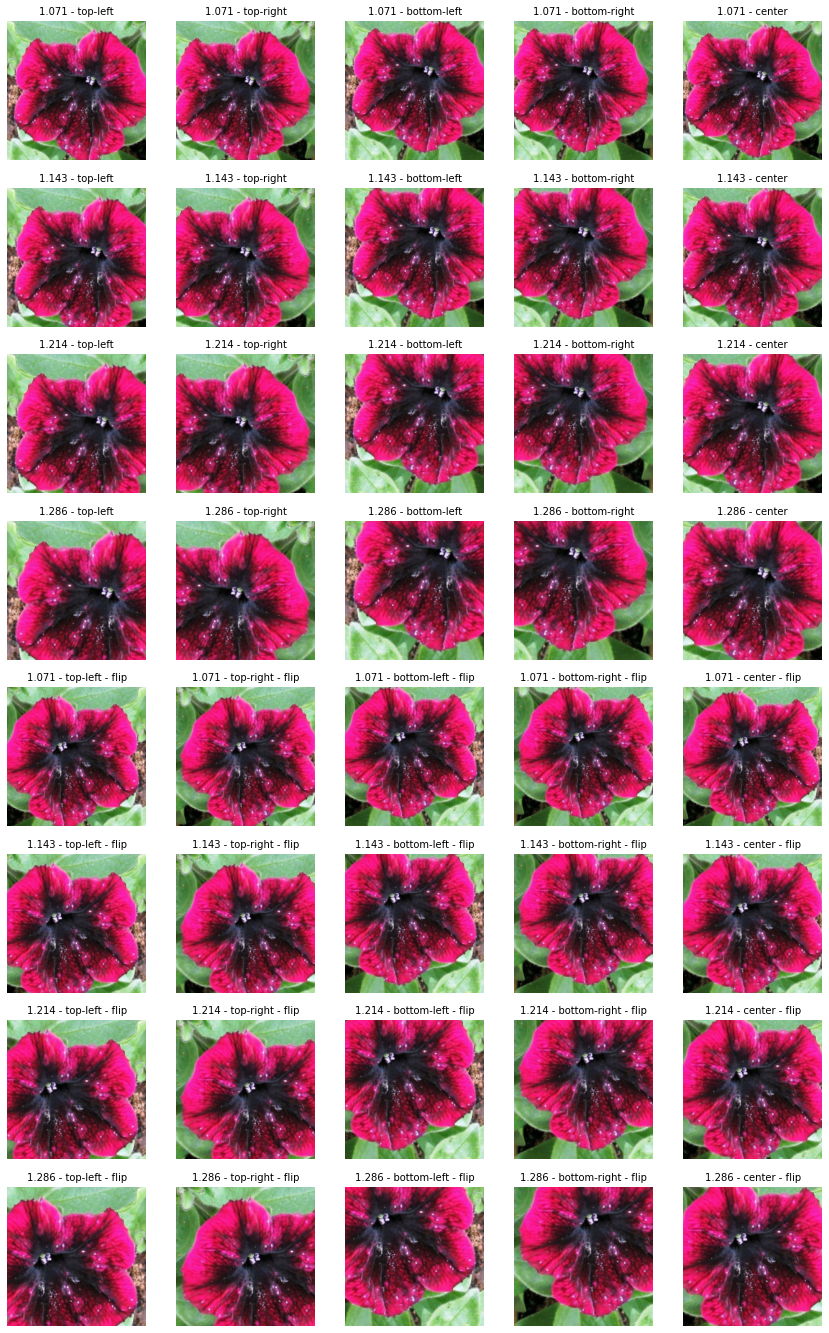

In [23]:
b = next(ds_tta_iter)
show_images(b['image'][2:], titles, rc=(8,5))

## Prediction Procedures

The following prediction procedures are evaluated against baseline predictions for the original images only:
* Argmax of average of softmax probs of each image version
* Mode of argmax of softmax probs of each image version
* Argmax of softmax of average of logits of each image version

In [24]:
pred_tta = model.predict(ds_pred_tta_pp)

id_list_tta = []
label_list_tta = []
class_list_tta = []

for b in ds_pred_tta.as_numpy_iterator():
    id_list_tta.extend(b['id'].squeeze())
    label_list_tta.extend(b['label'].squeeze())
    class_list_tta.extend(b['class'].squeeze())

In [25]:
df_pred_tta = pd.DataFrame(pred_tta)
df_pred_tta['id'] = id_list_tta
df_pred_tta['label'] = label_list_tta
df_pred_tta['tta_version'] = (['orig', 'orig - flip'] + titles) * (val_steps * batch_size)

### Baseline

In [26]:
df_pred_tta_base = df_pred_tta[df_pred_tta.tta_version == 'orig'].copy()
df_pred_tta_base['label_pred'] = (df_pred_tta_base[range(len(CLASSES))]
                                   .apply(lambda s: np.argmax(s.values), axis=1))
f1_report_base = classification_report(df_pred_tta_base.label, \
                                       df_pred_tta_base.label_pred, \
                                       output_dict=True)
print(f1_report_base['macro avg'])

{'precision': 0.9150101128864466, 'recall': 0.9324187395837561, 'f1-score': 0.9199991542464729, 'support': 3712}


### Argmax of average softmax probabilities

In [27]:
agg_dict = {c: 'mean' for c in range(len(CLASSES))}
agg_dict['label'] = 'max'

df_pred_tta_avg = df_pred_tta.groupby('id').agg(agg_dict)
df_pred_tta_avg['label_pred'] = (df_pred_tta_avg[range(len(CLASSES))]
                                   .apply(lambda s: np.argmax(s.values), axis=1))
f1_report_avg = classification_report(df_pred_tta_avg.label,\
                                      df_pred_tta_avg.label_pred, \
                                      output_dict=True)
print(f1_report_avg['macro avg'])

{'precision': 0.9282505718695588, 'recall': 0.9394925703292061, 'f1-score': 0.9310451572115727, 'support': 3712}


### Argmax of max softmax probabilities

In [28]:
agg_dict = {c: 'max' for c in range(len(CLASSES))}
agg_dict['label'] = 'max'

df_pred_tta_max = df_pred_tta.groupby('id').agg(agg_dict)
df_pred_tta_max['label_pred'] = (df_pred_tta_max[range(len(CLASSES))]
                                   .apply(lambda s: np.argmax(s.values), axis=1))
f1_report_max = classification_report(df_pred_tta_max.label,
                                      df_pred_tta_max.label_pred,
                                      output_dict=True)
print(f1_report_max['macro avg'])

{'precision': 0.9274762630106317, 'recall': 0.9377154794016692, 'f1-score': 0.9296052294062332, 'support': 3712}


### Mode of argmax of softmax probabilities

In [29]:
agg_dict = {'label': 'max',  'label_pred': lambda s: s.value_counts().index[0]}

df_pred_tta_mode = df_pred_tta.copy()
df_pred_tta_mode['label_pred'] = (df_pred_tta_mode[range(len(CLASSES))]
                                   .apply(lambda s: np.argmax(s.values), axis=1))

df_pred_tta_mode = df_pred_tta_mode[['id', 'label', 'label_pred']]
df_pred_tta_mode = df_pred_tta_mode.groupby('id').agg(agg_dict)
f1_report_mode = classification_report(df_pred_tta_mode.label, \
                                       df_pred_tta_mode.label_pred, \
                                       output_dict=True)
print(f1_report_mode['macro avg'])

{'precision': 0.9248911226085035, 'recall': 0.9382148562576104, 'f1-score': 0.9283924955749543, 'support': 3712}


### Argmax of softmax of average logits

In [30]:
with strategy.scope():
    pred_model_logits = tf.keras.Model(model.input, \
                                       model.output.op.inputs[0])
logits = pred_model_logits.predict(ds_pred_tta_pp)

In [31]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [32]:
df_pred_tta_logits = pd.DataFrame(logits)
df_pred_tta_logits['id'] = id_list_tta
df_pred_tta_logits['label'] = label_list_tta

In [33]:
agg_dict = {c: 'mean' for c in range(len(CLASSES))}
agg_dict['label'] = 'max'

df_pred_tta_logits_avg = df_pred_tta_logits.groupby('id').agg(agg_dict)
df_pred_tta_logits_avg['label_pred'] = (df_pred_tta_logits_avg[range(len(CLASSES))]
                                   .apply(lambda s: softmax(s), axis=1)
                                   .apply(lambda s: np.argmax(s.values), axis=1)) 
f1_report_logits_avg = classification_report(df_pred_tta_logits_avg.label, \
                                             df_pred_tta_logits_avg.label_pred, \
                                             output_dict=True)
print(f1_report_logits_avg['macro avg'])

{'precision': 0.9282505718695588, 'recall': 0.9394925703292061, 'f1-score': 0.9310451572115727, 'support': 3712}


## Summary

The baseline macro f1-score s 0.921. The best score of 0.933 results from averaging softmax probs, a 16% reduction in total error (numbers may vary slightly with different runs of this book).

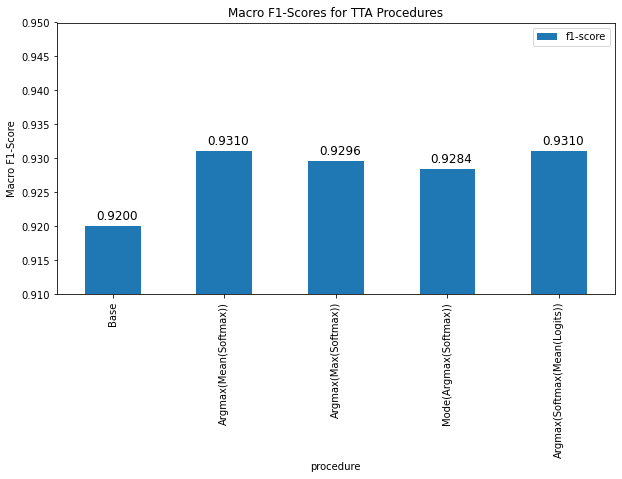

In [34]:
procs = ['Base', 'Argmax(Mean(Softmax))', 'Argmax(Max(Softmax))', 'Mode(Argmax(Softmax))', 'Argmax(Softmax(Mean(Logits))']
tta_results = [f1_report_base, f1_report_avg, f1_report_max, f1_report_mode, f1_report_logits_avg]

f1_scores = [res['macro avg']['f1-score'] for res in tta_results]

ax = pd.DataFrame(zip(procs, f1_scores), columns=['procedure', 'f1-score']).set_index('procedure').plot(kind='bar', figsize=(10,5))

for i in ax.patches:
    x = i.get_x()
    y = i.get_height()
    ax.text(x+.1,y+.001,f'{y:0.4f}',fontsize=12)

ax.set_ylabel('Macro F1-Score')
ax.set_title('Macro F1-Scores for TTA Procedures')
ax.set_ylim((.91,.95));

## Additional Experiments

One thing I was also curious about was how the different tta versions may be contributing to overall prediction performance. The chart below shows the macro f1-score for each tta version. This is sort of interesting - it basically shows that performance declines as the scaling factor goes up and that the center crops perform better than the corner ones do.

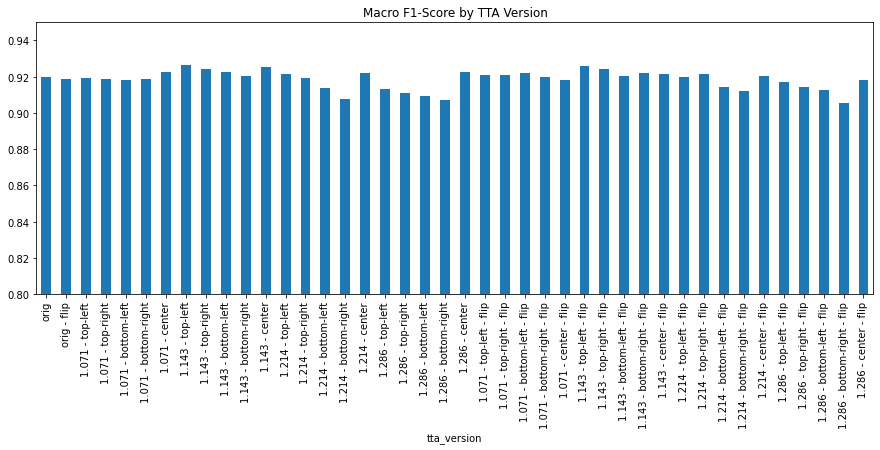

In [35]:
tta_ver_f1_scores = []
for t in df_pred_tta.tta_version.unique():
    df_pred_tta_ver = df_pred_tta[df_pred_tta.tta_version == t].copy()
    df_pred_tta_ver['label_pred'] = (df_pred_tta_ver[range(len(CLASSES))]
                                    .apply(lambda s: np.argmax(s.values), axis=1))
    f1_report_ver = classification_report(df_pred_tta_ver.label, \
                                          df_pred_tta_ver.label_pred, \
                                          output_dict=True)
    f1_report_ver['macro avg']['tta_version'] = t
    tta_ver_f1_scores.append(f1_report_ver['macro avg'])
df_tta_pred_ver = pd.DataFrame(tta_ver_f1_scores).set_index('tta_version')
ax = df_tta_pred_ver['f1-score'].plot(kind='bar', figsize=(15,5), title='Macro F1-Score by TTA Version')
ax.set_ylim((0.8, 0.95));

Let's see if performance improves under each of the following scenarios:
* Original and flip
* Original, flip and center crops
* Original and flip for the first scaling level

To keep things simple I'm just going to argmax the average probabilities. Predictions for the originals and all tta versions are included for reference.

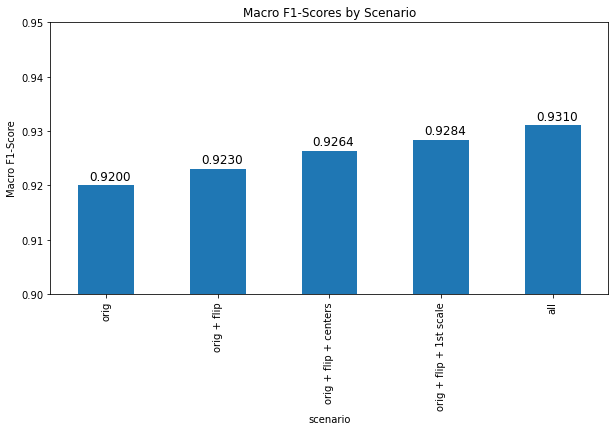

In [36]:
scenarios = {'orig': ['orig'],
             'orig + flip': ['orig', 'orig - flip'],
             'orig + flip + centers': ['orig', 'orig - flip'] + [v for v in titles if 'center' in v],
             'orig + flip + 1st scale': ['orig', 'orig - flip'] + [v for v in titles if '1.143' in v],
             'all': ['orig', 'orig - flip'] + titles,
        }

def get_tta_ver_score(scenario, versions=['orig']):
    agg_dict = {c: 'mean' for c in range(len(CLASSES))}
    agg_dict['label'] = 'max'

    df_pred_tta_ver = df_pred_tta[df_pred_tta.tta_version.isin(versions)].copy()
    df_pred_tta_ver = df_pred_tta_ver.groupby('id').agg(agg_dict)
    df_pred_tta_ver['label_pred'] = (df_pred_tta_ver[range(len(CLASSES))]
                                    .apply(lambda s: np.argmax(s.values), axis=1))
    f1_report_ver = classification_report(df_pred_tta_ver.label, \
                                            df_pred_tta_ver.label_pred, \
                                            output_dict=True)
    f1_report_ver['macro avg']['scenario'] = scenario
    return f1_report_ver['macro avg']

ax = pd.DataFrame([get_tta_ver_score(s, vers) for s, vers in scenarios.items()]).set_index('scenario')['f1-score'].plot(kind='bar', figsize=(10,5))

for i in ax.patches:
    x = i.get_x()
    y = i.get_height()
    ax.text(x+.1,y+.001,f'{y:0.4f}',fontsize=12)

ax.set_ylabel('Macro F1-Score')
ax.set_title('Macro F1-Scores by Scenario')
ax.set_ylim((.9,.95));

# Push Kernel

In [37]:
if False:
    if not KAGGLE:
        DATASET_DIR.mkdir(exist_ok=True)
              
        data = {"licenses": [{"name": "CC0-1.0"}],
                "id": f"calebeverett/{str(DATASET_DIR)}", 
                "title": str(DATASET_DIR)}
        
        with open(f'{DATASET_DIR}/dataset-metadata.json', 'w') as f:
            json.dump(data, f)
        
        for f in ['classes.csv']:
          bucket.blob(f).download_to_filename(f'{DATASET_DIR}/{f}')

        print_output(run_command(f'kaggle datasets create -r tar -p {str(DATASET_DIR)}'))

In [38]:
if False:
    if not KAGGLE:

        run_command('cp "drive/My Drive/Colab Notebooks/Comparison of TTA Prediction Procedures.ipynb" .')

        data = {'id': 'calebeverett/comparison-of-tta-prediction-procedures',
                      'title': 'Comparison of TTA Prediction Procedures',
                      'code_file': 'Comparison of TTA Prediction Procedures.ipynb',
                      'language': 'python',
                      'kernel_type': 'notebook',
                      'is_private': 'true',
                      'enable_gpu': 'false',
                      'enable_internet': 'true',
                      'dataset_sources': [f"calebeverett/{str(DATASET_DIR)}"],
                      'competition_sources': ['flower-classification-with-tpus'],
                     ' kernel_sources': []}
        
        with open('kernel-metadata.json', 'w') as f:
            json.dump(data, f)

        print_output(run_command('kaggle kernels push'))